In [61]:
import pandas as pd
import numpy as np
import seaborn as sas
import matplotlib.pyplot as pyp
import sqlalchemy
import datetime
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy import Column, Integer, String, Float
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, or_, and_
from sqlalchemy_utils import database_exists, create_database
Base = automap_base()
sas.set()

In [2]:
engine = create_engine('sqlite:///resources/hawaii.sqlite')

if not database_exists(engine.url):
    create_database(engine.url)
conn = engine.connect()

In [3]:
# Create the garbage_collection table within the database
Base.prepare(engine,reflect=True)
print(Base.classes.keys())
# To push the objects made and query the server we use a Session object

session = Session(bind=engine)

['measurements', 'stations']


In [4]:
measurements = Base.classes.measurements
stations = Base.classes.stations

TypeError: 'DeclarativeMeta' object is not iterable

In [7]:
first_row = session.query(stations).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1de4874f710>,
 'alt': 3.0,
 'lat': 21.2716,
 'lon': -157.8168,
 'station_id': 'USC00519397',
 'station_name': 'WAIKIKI 717.2, HI US'}

In [12]:
now = datetime.datetime.today()
strnow = now.strftime('%Y-%m-%d')
then = now-datetime.timedelta(weeks=52)
strthen = then.strftime('%Y-%m-%d')

In [27]:
def timewarp(newdt=datetime.datetime.today()):
    now = newdt
    strnow = now.strftime('%Y-%m-%d')
    then = now-datetime.timedelta(weeks=52)
    strthen = then.strftime('%Y-%m-%d')
    return (strnow, strthen)

In [56]:
def lastTwelveMonths():
    retTuple = timewarp()
    q1 = session.query(measurements).filter(measurements.precip!=None)
    return q1.filter(and_(measurements.date<= retTuple[0],measurements.date>=retTuple[1]))

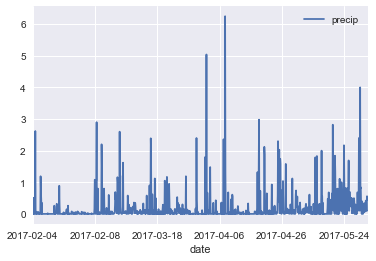

,precip
count,1077.000000
mean,0.184104
std,0.477664
min,0.000000
25%,0.000000
50%,0.010000
75%,0.130000
max,6.250000


In [97]:
queryAnswer = lastTwelveMonths()
df1 = pd.read_sql(queryAnswer.statement,queryAnswer.session.bind)
df1 = df1[['date','precip']]
df1.set_index('date',inplace=True)
df1.plot()
pyp.show()

df1.describe()

Station analysis

In [65]:
session.query(stations).count()

9

In [102]:
all_items=[]
for row in session.query(measurements.station_id,func.count(measurements.station_id)).group_by(measurements.station_id).order_by(func.count(measurements.station_id).desc()):
    all_items.append((session.query(stations.station_name).filter(stations.station_id==row[0]).first()[0],row[0],row[1]))
print(all_items)
print(all_items[0][0],' had highest obvs cnt')

[('WAIHEE 837.5, HI US', 'USC00519281', 2772), ('WAIKIKI 717.2, HI US', 'USC00519397', 2724), ('KANEOHE 838.1, HI US', 'USC00513117', 2709), ('WAIMANALO EXPERIMENTAL FARM, HI US', 'USC00519523', 2669), ('MANOA LYON ARBO 785.2, HI US', 'USC00516128', 2612), ('KUALOA RANCH HEADQUARTERS 886.9, HI US', 'USC00514830', 2202), ('HONOLULU OBSERVATORY 702.2, HI US', 'USC00511918', 1979), ('PEARL CITY, HI US', 'USC00517948', 1372), ('UPPER WAHIAWA 874.3, HI US', 'USC00518838', 511)]
WAIHEE 837.5, HI US  had highest obvs cnt


In [75]:
func.count(measurements.station_id)

<sqlalchemy.sql.functions.count at 0x1de4b83d358; count>

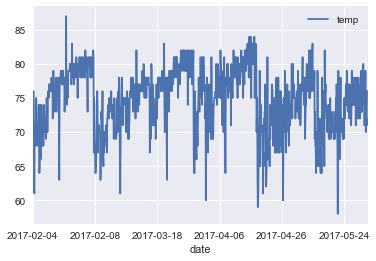

,temp
count,1077.000000
mean,74.892293
std,4.552820
min,58.000000
25%,72.000000
50%,76.000000
75%,78.000000
max,87.000000


In [103]:
queryAnswer = lastTwelveMonths()
df2 = pd.read_sql(queryAnswer.statement,queryAnswer.session.bind)
df3 = df2[['date','temp']]
df3.set_index('date',inplace=True)
df3.plot()
pyp.show()

df3.describe()

In [122]:
df2.groupby('station_id')['temp'].head()

0      72
1      73
2      76
3      64
4      62
196    67
197    75
198    74
199    67
200    67
374    77
375    76
376    67
377    71
378    73
517    67
518    64
519    64
520    64
521    76
551    76
552    77
553    76
554    72
555    74
719    70
720    73
721    75
722    64
723    59
906    69
907    73
908    68
909    68
910    64
Name: temp, dtype: int64

In [180]:
df4.head()

,date,temp
719,2017-02-04,70
720,2017-02-05,73
721,2017-02-06,75
722,2017-02-07,64
723,2017-02-08,59


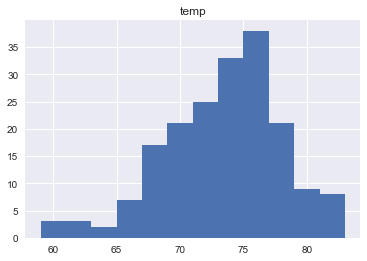

In [190]:
 df4 = df2.loc[lambda row: row['station_id']==all_items[0][1],:][['date','temp']]#.set_index('date')
df4['date']=df4['date'].apply(lambda x:int (datetime.datetime.strptime(x,'%Y-%m-%d').strftime('%m')))
df4.hist(column='temp',bins=12)
pyp.show()

In [192]:
def calc_temps(date1, date2):
    retTuple = timewarp()
    now = datetime.datetime.strptime(date1,'%Y-%m-%d')
    strnow = now.strftime('%Y-%m-%d')
    then = datetime.datetime.strptime(date2,'%Y-%m-%d')
    strthen = then.strftime('%Y-%m-%d')
    retTuple = (strnow, strthen)
    q1 = session.query(measurements).filter(measurements.temp!=None)
    q2 = q1.filter(and_(measurements.date<= retTuple[0],measurements.date>=retTuple[1]))
    df9 = pd.read_sql(q2.statement,q2.session.bind)
    return (df9, df9['temp'].mean(),df9['temp'].max(),df9['temp'].min())
    

In [193]:
calc_temps('2018-02-02','2017-02-02')

(         id   station_id        date  precip  temp
 0      2526  USC00519397  2017-02-02    0.00    61
 1      2527  USC00519397  2017-02-03    0.00    65
 2      2528  USC00519397  2017-02-04    0.00    72
 3      2529  USC00519397  2017-02-05    0.00    73
 4      2530  USC00519397  2017-02-06    0.00    76
 5      2531  USC00519397  2017-02-07    0.51    64
 6      2532  USC00519397  2017-02-08    0.00    62
 7      2533  USC00519397  2017-02-09    0.00    61
 8      2534  USC00519397  2017-02-10    0.00    71
 9      2535  USC00519397  2017-02-11    0.31    69
 10     2536  USC00519397  2017-02-12    2.62    68
 11     2537  USC00519397  2017-02-13    0.01    74
 12     2538  USC00519397  2017-02-14    0.00    75
 13     2539  USC00519397  2017-02-15    0.00    75
 14     2540  USC00519397  2017-02-16    0.07    71
 15     2541  USC00519397  2017-02-17    0.00    71
 16     2542  USC00519397  2017-02-18    0.00    68
 17     2543  USC00519397  2017-02-19    0.00    69
 18     2544

In [205]:
def plot_temps(date1,date2):
    curTup =calc_temps(date1,date2)
    pyp.bar('temp',curTup[1],yerr=(curTup[2]-curTup[3])/2)
    pyp.show()

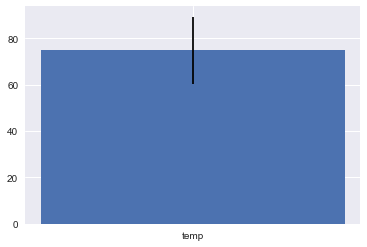

In [206]:
plot_temps('2018-02-02','2017-02-02')